TODO:
* experiment with narrower sampling of thetas / less trials / fixed presentation time
* analysis with train set / test set

In [14]:
%run experiment1.ipynb

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.0

numpy       : 1.26.4
MotionClouds: 20220927
manim       : 0.18.1
pandas      : 2.2.3
matplotlib  : 3.10.1
scipy       : 1.15.2

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Hostname: obiwan.local



## one logistic regression per session with an influence of B_theta (WIP not started)

Some inductive biases:

* the lapse rate is independent of `B_theta`
* the slope is proportional to `B_theta` and should decrease with it

In [2]:
# %whos

In [12]:
theta_trials = np.array(parameters['theta'])*180/np.pi
theta_max = theta_trials.max()
B_theta_trials = np.array(parameters['B_theta'])*180/np.pi
B_thetas = np.sort(np.array(parameters['B_theta'].unique()))*180/np.pi
B_thetas

array([ 6.66666667, 13.33333333, 20.        , 26.66666667, 33.33333333,
       40.        , 46.66666667, 53.33333333, 60.        ])

In [ ]:
# Best params:  {'batch_size': 2, 'log_wt_B_theta': -8.707058467440726, 'etab1': 0.01074563304390269, 'etab2': 0.00011668431952396083, 'learning_rate': 0.003490116226129931, 'amsgrad': True, 'logit0': -1.794325813837763, 'log_wt': 2.191751816905336}
# -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
# Best params: {'batch_size': 2, 'log_wt': 6.445507418370991, 'log_wt_B_theta': -7.9477128475754135, 'etab1': 0.024603889307962715, 'etab2': 0.0003026550144834277, 'learning_rate': 0.011948713670969013, 'amsgrad': False, 'logit0': 0.63151024499213}
# Best value: 0.551 at 2025-03-18 08:46:43
# --------------------------------------------------
learning_rate = 0.01
etab1, etab2 = 0.02, 0.0003
num_epochs = 2 ** 9 + 1
batch_size = 2
amsgrad = True
logit0 = -2.
log_wt = 6.
log_wt_B_theta = -8.
theta0 = 0.
frozen_theta0 = True

In [5]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0=logit0, theta0=theta0, log_wt=log_wt, log_wt_B_theta=log_wt_B_theta, frozen_theta0=False):
        super(LogisticRegressionModel, self).__init__()
        # self.theta0 = torch.nn.Parameter(theta0 * torch.ones(1))
        self.theta0 = torch.nn.Parameter(torch.tensor(theta0))
        if frozen_theta0: self.theta0.requires_grad = False
        self.logit0 = torch.nn.Parameter(torch.tensor(logit0))
        self.log_wt = torch.nn.Parameter(torch.tensor(log_wt))
        self.log_wt_B_theta = torch.nn.Parameter(torch.tensor(log_wt_B_theta))

    def forward(self, theta, B_theta):
        p0 = torch.sigmoid(self.logit0)
        output = p0 / 2 + (1 - p0) * torch.sigmoid((theta-self.theta0)/torch.exp(self.log_wt + self.log_wt_B_theta / B_theta))
        return output
    
def fit_data(
    theta_trials,
    B_theta_trials,
    y,
    logit0=logit0, theta0=theta0, log_wt=log_wt, log_wt_B_theta=log_wt_B_theta, 
    learning_rate=learning_rate,
    batch_size=batch_size,  
    amsgrad=amsgrad, frozen_theta0=frozen_theta0,
    num_epochs=num_epochs,
    etab1=etab2, etab2=etab2,
    verbose=False
):

    theta_trials, B_theta_trials, labels = torch.Tensor(theta_trials[:, None]), torch.Tensor(B_theta_trials[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(theta_trials, B_theta_trials, labels), batch_size=batch_size, shuffle=True
    )

    total_loss = torch.log(torch.tensor(2)) # criterion(outputs, labels_)

    logistic_model = LogisticRegressionModel(logit0=logit0, log_wt=log_wt, log_wt_B_theta=log_wt_B_theta, theta0=theta0, frozen_theta0=frozen_theta0)

    logistic_model = logistic_model.to(device)
    logistic_model.train()
    
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=(1-etab1, 1-etab2), amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for theta_, B_theta_, labels_ in loader:
            theta_, B_theta_, labels_ = theta_.to(device), B_theta_.to(device), labels_.to(device)

            outputs = logistic_model(theta_, B_theta_)
            # print(outputs, labels_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta_trials):.3e}")
            # print(f"Iteration: {epoch} - Evidence: {-np.mean(losses):.3e}")

    logistic_model.eval()
    outputs = logistic_model(theta_trials, B_theta_trials)
    loss = criterion(outputs, labels).item()
    # loss = - logistic_model.evidence(outputs, labels).item()
    return logistic_model, loss / total_loss


frozen_theta0=False
.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*
for apagrpwbxf, Loss = 5.205e-01 - theta0 = -0.80°, p0 = 3.52e-02, slope = 1.18e+01 x 2.16e-10
for w87npww874, Loss = 4.629e-01 - theta0 = -3.23°, p0 = 1.33e-01, slope = 3.54e+00 x 2.23e-06
for 64dtdq27os, Loss = 6.977e-01 - theta0 = 1.84°, p0 = 1.05e-01, slope = 1.26e+01 x 6.31e-07
for w2oz9j2a3v, Loss = 6.901e-01 - theta0 = 6.58°, p0 = 1.29e-02, slope = 1.85e+01 x 1.28e-07
for wsumnmxd8c, Loss = 4.295e-01 - theta0 = -0.00°, p0 = 1.88e-02, slope = 8.44e+00 x 4.61e-09
for rtumbda4hz, Loss = 6.078e-01 - theta0 = 3.93°, p0 = 1.19e-02, slope = 1.34e+01 x 3.24e-07
for ybaxemnk16, Loss = 4.562e-01 - theta0 = 0.47°, p0 = 6.25e-02, slope = 7.55e+00 x 9.40e-08
for 6l605rv4nn, Loss = 7.540e-01 - theta0 = 1.06°, p0 = 1.47e-01, slope = 1.78e+01 x 5.44e-11
for t7vs2ac7eg, Loss = 4.218e-01 - theta0 = 0.09°, p0 = 9.45e-04, slope = 

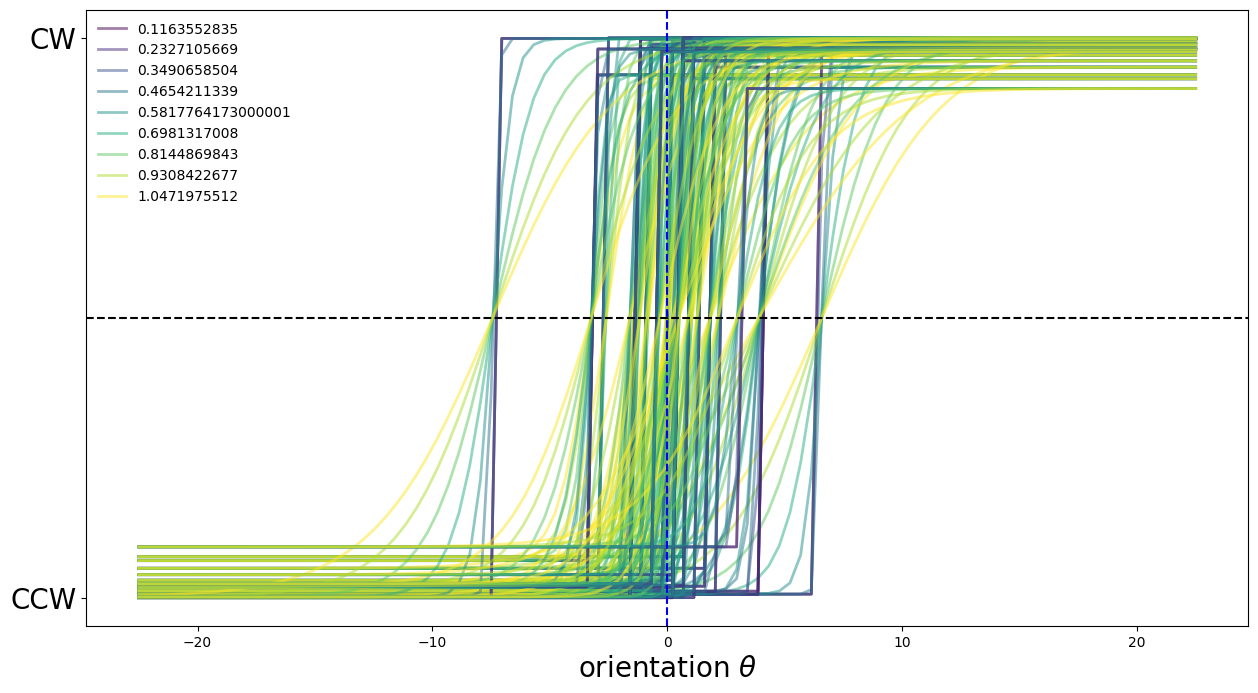

frozen_theta0=True
.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*
for apagrpwbxf, Loss = 5.256e-01 - theta0 = 0.00°, p0 = 2.92e-02, slope = 1.24e+01 x 1.59e-10
for w87npww874, Loss = 5.117e-01 - theta0 = 0.00°, p0 = 5.20e-02, slope = 6.52e+00 x 5.04e-04
for 64dtdq27os, Loss = 7.006e-01 - theta0 = 0.00°, p0 = 8.13e-02, slope = 1.40e+01 x 3.22e-07
for w2oz9j2a3v, Loss = 7.314e-01 - theta0 = 0.00°, p0 = 1.09e-02, slope = 1.86e+01 x 3.97e-07
for wsumnmxd8c, Loss = 4.293e-01 - theta0 = 0.00°, p0 = 1.95e-02, slope = 8.45e+00 x 4.22e-09
for rtumbda4hz, Loss = 6.346e-01 - theta0 = 0.00°, p0 = 2.31e-02, slope = 1.42e+01 x 2.01e-07
for ybaxemnk16, Loss = 4.604e-01 - theta0 = 0.00°, p0 = 1.05e-01, slope = 5.31e+00 x 8.76e-08
for 6l605rv4nn, Loss = 7.565e-01 - theta0 = 0.00°, p0 = 1.72e-01, slope = 1.77e+01 x 3.73e-11
for t7vs2ac7eg, Loss = 4.209e-01 - theta0 = 0.00°, p0 = 1.07e-03, slope = 9.92

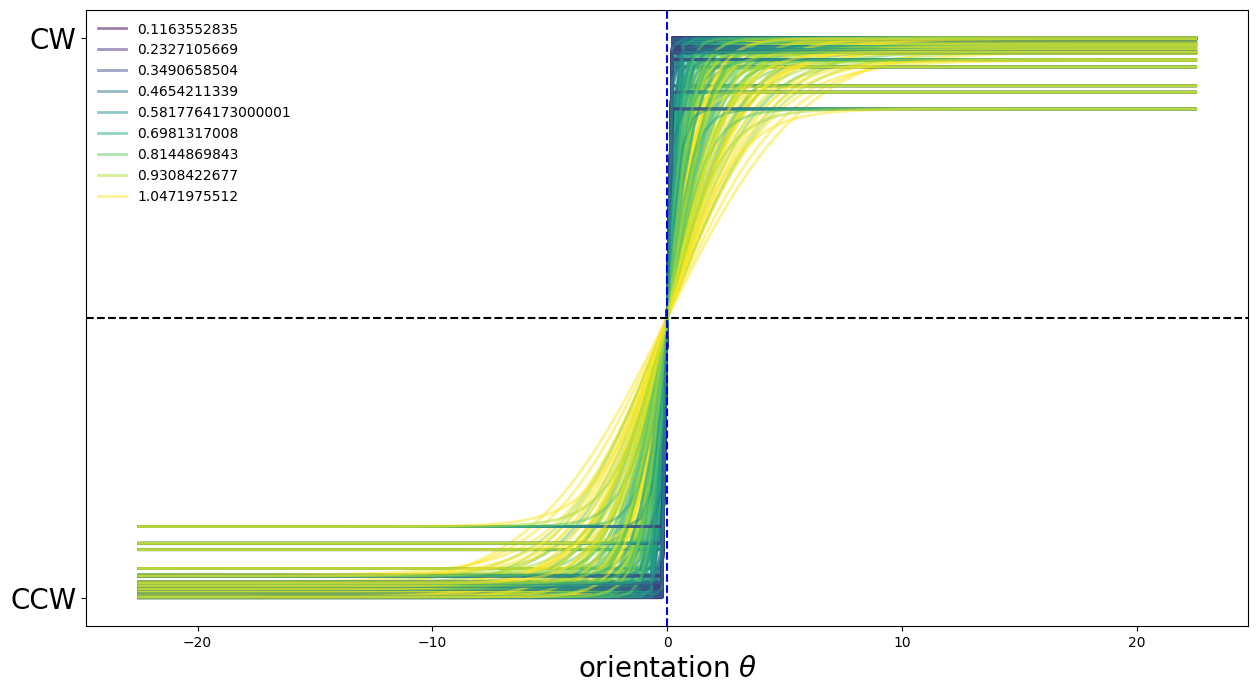

In [7]:
# for the plot
x_values = np.linspace(-theta_max, theta_max, 100)[:, None]
# Create a colormap
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=len(B_thetas) - 1)

for frozen_theta0 in [False, True]:

    print(f'{frozen_theta0=}')
    print(50*'.-*')
    
    fig, ax = plt.subplots(figsize=(15, 8))

    for session in responses.keys():    
        y = responses[session]

        logistic_model, loss = fit_data(theta_trials, B_theta_trials, y, frozen_theta0=frozen_theta0, verbose=False)

        print(f"for {session}, Loss = {loss:.3e} - theta0 = {logistic_model.theta0.item():.2f}°, p0 = {torch.sigmoid(logistic_model.logit0).item():.2e}, slope = {torch.exp(logistic_model.log_wt).item():.2e} x {torch.exp(logistic_model.log_wt_B_theta).item():.2e}")

        for i_B_theta, B_theta in enumerate(B_thetas):
            y_values = logistic_model(torch.Tensor(x_values), (i_B_theta*torch.ones_like(torch.Tensor(x_values)).long())).detach().numpy()
            color = cmap(norm(i_B_theta))
            ax.plot(x_values, y_values, color=color, alpha=0.5, lw=2, label=f'{B_theta}' if session==list(responses.keys())[0] else None)

    ax.set_xlabel(r"orientation $\theta$", fontsize=20)
    ax.axhline(.5, color='k', linestyle='--')
    ax.axvline(0., color='b', linestyle='--')
    ax.set_yticks([0.0, 1.0])
    ax.set_yticklabels(["CCW", "CW"], fontsize=20)
    ax.legend(fontsize=10, frameon=False, scatterpoints=6);
    plt.show();


### optimize learning parameters with optuna

In [8]:
logistic_model, loss = fit_data(theta_trials, B_theta_trials, y, verbose=True)

Iteration: 0 - Loss: 4.487e-02
Iteration: 16 - Loss: 4.344e-02
Iteration: 32 - Loss: 4.344e-02
Iteration: 48 - Loss: 4.347e-02
Iteration: 64 - Loss: 4.327e-02
Iteration: 80 - Loss: 4.302e-02
Iteration: 96 - Loss: 4.283e-02
Iteration: 112 - Loss: 4.275e-02
Iteration: 128 - Loss: 4.272e-02
Iteration: 144 - Loss: 4.266e-02
Iteration: 160 - Loss: 4.255e-02
Iteration: 176 - Loss: 4.241e-02
Iteration: 192 - Loss: 4.226e-02
Iteration: 208 - Loss: 4.213e-02
Iteration: 224 - Loss: 4.203e-02
Iteration: 240 - Loss: 4.197e-02
Iteration: 256 - Loss: 4.191e-02
Iteration: 272 - Loss: 4.186e-02
Iteration: 288 - Loss: 4.180e-02
Iteration: 304 - Loss: 4.173e-02
Iteration: 320 - Loss: 4.165e-02
Iteration: 336 - Loss: 4.157e-02
Iteration: 352 - Loss: 4.148e-02
Iteration: 368 - Loss: 4.140e-02
Iteration: 384 - Loss: 4.133e-02
Iteration: 400 - Loss: 4.128e-02
Iteration: 416 - Loss: 4.124e-02
Iteration: 432 - Loss: 4.120e-02
Iteration: 448 - Loss: 4.117e-02
Iteration: 464 - Loss: 4.113e-02
Iteration: 480 - L

In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_name = 'B_theta'
path_save_optuna = os.path.join('/tmp', f'optuna_{study_name}.sqlite3') # global name
# %rm {path_save_optuna}

In [10]:
def objective(trial):
    vars = dict(verbose = False,  num_epochs=num_epochs//2)
    max_threshold = .999
    vars['batch_size'] = trial.suggest_int('batch_size', 2, 64, log=True, step=1)
    scale = 10
    vars['log_wt'] = trial.suggest_float('log_wt', log_wt - scale, log_wt + scale, log=False)
    vars['log_wt_B_theta'] = trial.suggest_float('log_wt_B_theta', log_wt - scale, log_wt + scale, log=False)
    scale = 4
    vars['etab1'] = trial.suggest_float('etab1', etab1/scale, min(etab1*scale, max_threshold), log=True)
    vars['etab2'] = trial.suggest_float('etab2', etab2/scale, min(etab2*scale, max_threshold), log=True)
    vars['learning_rate'] = trial.suggest_float('learning_rate', learning_rate / scale, learning_rate * scale, log=True)
    vars['amsgrad'] = trial.suggest_categorical('amsgrad', [True, False])
    vars['logit0'] = trial.suggest_float('logit0', logit0 - scale, logit0 + scale, log=False)
    scale = 2
    # vars['theta0'] = trial.suggest_float('theta0', theta0 - scale, theta0 + scale, log=False)

    loss = 0
    for session in responses.keys():    
        y = responses[session]
        _, loss_ = fit_data(theta_trials, B_theta_trials, y, **vars)
        loss += loss_
    return loss/len(filenames_valid)


print(50*'=')
sampler = optuna.samplers.TPESampler(multivariate=True)
study = optuna.create_study(direction='minimize', load_if_exists=True, sampler=sampler, storage=f"sqlite:///{path_save_optuna}", study_name='LR')
study.optimize(objective, n_trials=max((200-len(study.trials), 0)), n_jobs=1, show_progress_bar=True)
print(50*'=')

/Users/laurentperrinet/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


  0%|          | 0/165 [00:00<?, ?it/s]

[W 2025-03-17 23:40:36,670] The parameter 'log_wt' in trial#36 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
[W 2025-03-17 23:40:36,672] The parameter 'log_wt_B_theta' in trial#36 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
[W 2025-03-17 23:40:36,676] The parameter 'etab2' in trial#36 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of

In [15]:
print(50*'-.')
print(f"Best params: {study.best_params}")
print(f"Best value: {study.best_value:.3f} at {now.strftime("%Y-%m-%d %H:%M:%S")}")
print(50*'-')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params: {'batch_size': 2, 'log_wt': 6.445507418370991, 'log_wt_B_theta': -7.9477128475754135, 'etab1': 0.024603889307962715, 'etab2': 0.0003026550144834277, 'learning_rate': 0.011948713670969013, 'amsgrad': False, 'logit0': 0.63151024499213}
Best value: 0.551 at 2025-03-18 08:46:43
--------------------------------------------------
